In [320]:
# %load Heisenberg.py
import numpy as np
from numpy import linalg as LA
import time as t
import matplotlib.pyplot as plt
plt.tight_layout()

def randomGaussianArray(length, mu, sigma):
    return np.random.normal(mu, sigma, length)

def randomUniformArray(length, minimum, maximum):
    return np.random.uniform(minimum, maximum,length)

def getBit(intState,i):
    return (intState >> i) & 1

def flipIJ(intState, i, j):
    iBit = getBit(intState,i)
    jBit = getBit(intState,j)
    x = iBit ^ jBit
    x = (x << i) | (x << j)
    return x ^ intState

def binaryStateToIntegerState(binString): 
    return int(binString,2)

def integerStateToBinaryState(intState,length):
    return bin(intState)[2:].zfill(length)

def allowedIntegerStates(length, numParticles): 
    allowedStateSet = []
    startState = 2**numParticles - 1
    allowedStateSet.append(startState)
    endState = startState << (length - numParticles)
    
    iteratorState = startState
    leadingBitPosition = numParticles - 1
    trailingBitPosition = 0

    while(not(iteratorState == endState)):
        if numParticles == 1:
            if (iteratorState >> leadingBitPosition + 1) & 1:
                numParticles += 1
                leadingBitPosition += 1
                continue
            iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
            leadingBitPosition += 1
            trailingBitPosition += 1
            allowedStateSet.append(iteratorState)
            continue

        if (iteratorState >> leadingBitPosition + 1) & 1:
            numParticles += 1
            leadingBitPosition += 1
            continue

        iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
        for i in range(leadingBitPosition+1):
            if i<(numParticles-1):
                iteratorState = iteratorState | (1 << i)
            else:
                helper = ((iteratorState >> i) & 1)
                iteratorState = iteratorState ^ (helper << i)

        allowedStateSet.append(iteratorState)
        leadingBitPosition = numParticles - 2
        trailingBitPosition = 0
        numParticles -= 1
    
    return allowedStateSet

#conserved up spins (numParticles)
class SpinHalfChain:
    def __init__(self, length, numParticles):
        
        self.length = length
        self.numParticles = numParticles
        self.allowedIntStateBasis = allowedIntegerStates(length,numParticles)
        self.basisDimension = len(self.allowedIntStateBasis)
        
        self.bitFlags = [0]*length
        for i in range(length): 
            self.bitFlags[i] = 2**i
        
        self.allowedStateIndexDictionary = []
        self.initalizeStateIndexDictionary()
        
        self.precomputeSpinZExpectationValues()
        self.createM1()
        
        
    def initalizeStateIndexDictionary(self):
        self.allowedStateIndexDictionary = [self.basisDimension] * (2**self.length)
        i = 0
        for a in self.allowedIntStateBasis:
            self.allowedStateIndexDictionary[a] = i
            i = i+1
    
    def precomputeSpinZExpectationValues(self):
        self.spinZExpectationValues = -0.5*np.ones((self.length,self.basisDimension))
        for i in range(self.length):
            for j in range(self.basisDimension):
                if getBit(self.allowedIntStateBasis[j],i): 
                    self.spinZExpectationValues[i,j] = .05
    
    def createM1(self):
        periodicPosition = np.exp(2j * np.pi * np.arange(self.length) / self.length)
        self.M1 = np.dot(np.transpose(self.spinZExpectationValues),periodicPosition)
    
    def createHeisenbergBaseHamiltonian(self, J):
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        dictionary = self.allowedStateIndexDictionary
        
        ham = np.zeros((dim,dim))
        indA = 0
        for a in allowedStates:
            for i in range(0, length):
                j = (i+1) % length
                
                iBit = getBit(a,i)
                jBit = getBit(a,j)
                
                if iBit == jBit:
                    ham[indA,indA] += (J * 0.25)
                else: 
                    ham[indA,indA] -= (J * 0.25)
                    b = flipIJ(a,i,j)
                    indB = dictionary[b]
                    ham[indA,indB] += (J * 0.25)
                    ham[indB,indA] += (J * 0.25)
            indA += 1
        return ham

    def HeisenbergDisorderInstance(self,h): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = randomUniformArray(length, -h, h)
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    
    def CorrFunct(self, nsq, site1, site2):
        S1 = self.spinZExpectationValues[site1,:]
        S2 = self.spinZExpectationValues[site2,:]
        return np.dot(np.multiply(S1,S2),nsq) - np.dot(S1,nsq)*np.dot(S2,nsq)
    
    
def figure2(Lvals,hvals,dvals):
    Fvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChain(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        M1sq = np.multiply(np.conj(chain.M1),chain.M1)
        for j in range(len(hvals)):
            for d in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for k in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,k],E[1][:,k])
                    halftop = np.dot(chain.M1,nsq)
                    Fvals[i,j] += (1 - ((halftop.real*halftop.real + halftop.imag*halftop.imag)/(np.dot(M1sq, nsq).real)))/((chain.basisDimension//3) *dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Fvals

def figure4(Lvals,hvals,dvals):
    Cvals = np.zeros((len(hvals),len(Lvals),Lvals[-1]//2))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChain(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for d in range(1,Lvals[i]//2 + 1):
                        for site in range(Lvals[i]):
                            Cvals[j,i,d-1] += chain.CorrFunct(nsq,site,(site+d)%Lvals[i])/((chain.basisDimension//3)*Lvals[i]*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Cvals

def figure56(Lvals,hvals,dvals):
    Cvals = np.zeros((len(Lvals),len(hvals),1))
    Cvals = Cvals.tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChain(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]//2):
                        Cvals[i][j].append(np.log(np.absolute(chain.CorrFunct(nsq,site,(site+Lvals[i]//2)%Lvals[i]))))
            del Cvals[i][j][0]
            print("h = " + str(hvals[j]) + " finished.")
    return np.array(Cvals)
    
    
def getEnergies(ham):
    return LA.eigvalsh(ham)

def getEnergyGaps(ham):
    eList = getEnergies(ham)
    return np.diff(eList)

def getRValues(ham):
    rValues = []
    eDiff = getEnergyGaps(ham)
    for i in range(1,len(eDiff)): 
        n = eDiff[i]
        m = eDiff[i-1]
        maximum = max(n,m)
        minimum = min(n,m)
        rValues.append(minimum/maximum)
    return rValues
        

def averageR(ham): 
    rValues = getRValues(ham)
    return np.mean(rValues)

L = 8 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
L = 10 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
L = 12 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
81.8365771517856


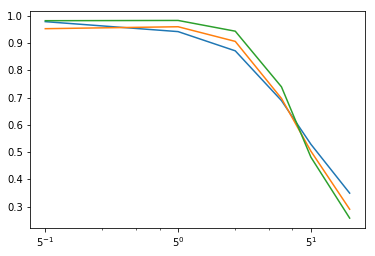

In [205]:
hlist1 = [.2,1,2,3.5,5,8]
hlist2 = [.2,1,5,25,125,625]
temp = t.clock()
f2 = figure2([8,10,12],hlist1,[5000,500,50])
print(t.clock()-temp)
out, sub = plt.subplots(1)
sub.semilogx(hlist1,f2[0],basex=5)
sub.semilogx(hlist1,f2[1],basex=5)
sub.semilogx(hlist1,f2[2],basex=5)
#sub.semilogx(hlist,f[3],basex=5)
#sub.semilogx(hlist,f[4],basex=5)
#sub.semilogx(hlist,f[5],basex=5)



out, sub = plt.subplots(1)
sub.plot([4,6,8,10,12,14],np.log([.014,.049,.22,1.4,21,1741]))

In [201]:
Llist = [8,10,12,14]
temp = t.clock() 
f4 = figure4(Llist,[.5,8],[200,50,10,4])
print(t.clock()-temp)

L = 8 started.
h = 0.5 finished.
h = 8 finished.
L = 10 started.
h = 0.5 finished.
h = 8 finished.
L = 12 started.
h = 0.5 finished.
h = 8 finished.
L = 14 started.
h = 0.5 finished.
h = 8 finished.
67.11894352629315


In [168]:
print(f4)

[[[-3.46448341 -3.53783274 -3.60555415 -3.63515295  0.
    0.        ]
  [-3.73342235 -3.84927931 -3.91805058 -3.95471627 -3.95792294
    0.        ]
  [-3.90337206 -4.02017268 -4.08777725 -4.15478631 -4.16542675
   -4.18736386]]

 [[-3.74827246 -3.83481748 -3.85794769 -3.87159601  0.
    0.        ]
  [-3.64148507 -3.74680481 -3.78708752 -3.79633504 -3.81922825
    0.        ]
  [-3.62663873 -3.73304997 -3.79671951 -3.85884944 -3.86496822
   -3.86075728]]]


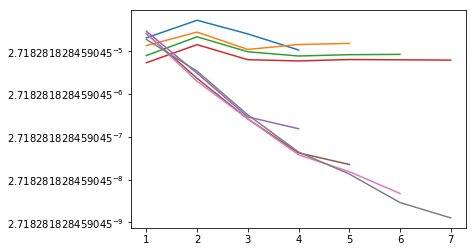

In [203]:
out,sub = plt.subplots(1)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[0,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[0,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[0,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[0,3],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[1,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[1,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[1,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[1,3],trim='b')), basey = np.e)

In [245]:
Llist = [8,10,12]
hlist = [2,4.5,6.5,8,10,14,20,26]
dlist = [1000,300,100]
temp = t.clock() 
f56 = figure56(Llist,hlist,dlist)
print(t.clock()-temp)

L = 8 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.
h = 20 finished.
h = 26 finished.
L = 10 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.
h = 20 finished.
h = 26 finished.
L = 12 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.
h = 20 finished.
h = 26 finished.
142.53092978161294


(array([5.43326239e-06, 1.08665248e-05, 5.97658863e-05, 1.41264822e-04,
        3.25995743e-04, 7.44356947e-04, 1.45068106e-03, 3.04806020e-03,
        5.99288841e-03, 1.09099909e-02, 1.63215202e-02, 2.44170812e-02,
        3.46098814e-02, 4.38735938e-02, 5.61962329e-02, 6.72583551e-02,
        7.84182761e-02, 8.82198814e-02, 9.25882244e-02, 9.09799787e-02,
        8.76602554e-02, 7.71577592e-02, 6.54110459e-02, 5.16159927e-02,
        3.79187382e-02, 2.79595683e-02, 1.92228823e-02, 1.25943022e-02,
        7.15017330e-03, 1.80384311e-03]),
 array([-32.56482004, -31.56887046, -30.57292087, -29.57697129,
        -28.58102171, -27.58507212, -26.58912254, -25.59317296,
        -24.59722337, -23.60127379, -22.60532421, -21.60937462,
        -20.61342504, -19.61747546, -18.62152588, -17.62557629,
        -16.62962671, -15.63367713, -14.63772754, -13.64177796,
        -12.64582838, -11.64987879, -10.65392921,  -9.65797963,
         -8.66203004,  -7.66608046,  -6.67013088,  -5.67418129,
      

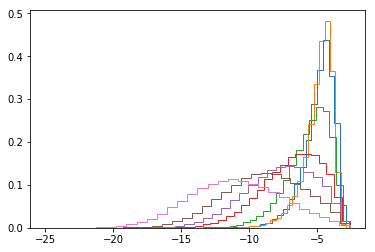

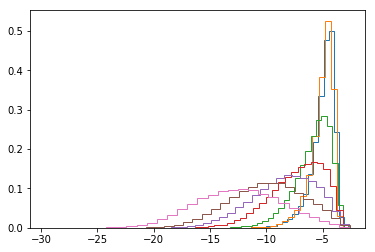

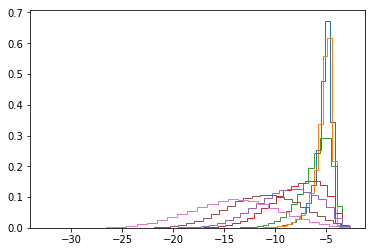

In [242]:
out0,sub0 = plt.subplots(1)
sub0.hist(f56[0][0],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][1],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][2],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][3],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][4],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][5],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][6],density='true',histtype = 'step',bins = 30)
out1,sub1 = plt.subplots(1)
sub1.hist(f56[1][0],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][1],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][2],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][3],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][4],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][5],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][6],density='true',histtype = 'step',bins = 30)
out2,sub2 = plt.subplots(1)
sub2.hist(f56[2][0],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][1],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][2],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][3],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][4],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][5],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][6],density='true',histtype = 'step',bins = 30)


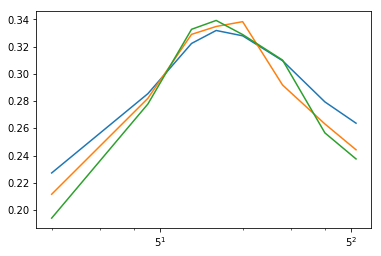

In [246]:
f6 = np.zeros((len(Llist), len(hlist)))
for i in range(len(Llist)):
    for j in range(len(hlist)):
        f6[i,j] = np.std(np.divide(f56[i][j],np.average(f56[i][j])))
out, sub = plt.subplots(1)
sub.semilogx(hlist, f6[0],basex=5)
sub.semilogx(hlist, f6[1],basex=5)
sub.semilogx(hlist, f6[2],basex=5)

In [323]:
hlist = [2,3,5,8,12]
temp = t.clock()
SerbynAbanin = BipartEntangleS([8,10,12,14],hlist,[1000,100,20,4])
print(t.clock()-temp)

L = 8 started.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
L = 10 started.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
L = 12 started.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
L = 14 started.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.


C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: divide by zero encountered in log


h = 12 finished.
1580.2873763281386


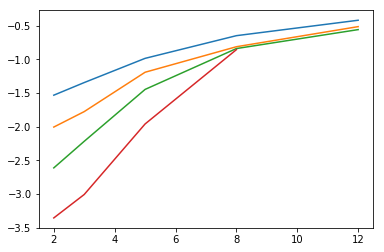

In [325]:
out,sub = plt.subplots(1)
sub.plot(hlist,SerbynAbanin[0])
sub.plot(hlist,SerbynAbanin[1])
sub.plot(hlist,SerbynAbanin[2])
sub.plot(hlist,SerbynAbanin[3])

In [287]:
chain = SpinHalfChain(8,4)
Hbase = chain.createHeisenbergBaseHamiltonian(1)
H = Hbase + chain.HeisenbergDisorderInstance(.5)
E = LA.eigh(H)
halfint = np.right_shift(chain.allowedIntStateBasis,4)
half = np.zeros(2**4)
test = np.ones(chain.basisDimension)
def testerr(x):
    half[int(x[0])] += x[1]
print(np.apply_along_axis(testerr,1,np.dstack((halfint,test))[0]))
print(half)
#print(E[0])
#nsq = np.multiply(E[1][11],E[1][11])
#nsq2 = np.multiply(E[1][:,11],E[1][:,11])
#print(np.subtract(nsq,nsq2))
#out,sub = plt.subplots(1)
#sub.plot(E[1][11])
#sub.plot(nsq)

[None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None]
[1. 4. 4. 6. 4. 6. 6. 4. 4. 6. 6. 4. 6. 4. 4. 1.]
